<p style="font-size:300%; background-color:pink; color:blue; text-align:center;line-height : 80px; margin : 0; padding : 0;">
Taller 5</p>
<p style="font-size:240%; background-color:pink; color:red; text-align:center;line-height : 60px; margin : 0; padding : 0;">
Técnicas de Inteligencia Artificial - Visión de Máquina</p1>

<p style="font-size:200%; text-align:center; line-height : 40px;  margin-top : 0; margin-bottom : 0; "> <br>Jose Eduardo Garnica Aza - Johan Sebastian Suarez Sepulveda</p>
<p style="font-size:160%; text-align:center; line-height : 20px; margin-top : 0; "> email: jgarnicaa@unal.edu.co email: jssuarezse@unal.edu.co</p>
<p style="font-size:180%; text-align:center; line-height : 30px;  margin-top : 0; margin-bottom : 0; "> <br><br>INGENIERÍA MECATRÓNICA</p>
<p style="font-size:180%; text-align:center; line-height : 30px; margin-top : 0; "> Facultad de Ingeniería</p>
<p style="font-size:160%; text-align:center; line-height : 30px; margin-top : 0; "> Universidad Nacional de Colombia Sede Bogotá</p>
<br>
<img src="Integrantes.png",width=10,height=10>
<p style="font-size:160%; text-align:center; line-height : 30px; margin-top : 0; "> <br>4 de mayo de 2022</p>

### Implementación de algoritmo para clasificación
    - Distancias encadenadas (Chain-map):

In [67]:
#librerias
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import numpy as np 
import math as m
import time
import timeit as tm
import cv2 as cv
import pandas as pd
from pylab import plot,subplot,axis,stem,show,figure
from numpy import mean,cov,double,cumsum,dot,linalg,array
import os
from scipy import signal
from scipy import misc

from sklearn import neighbors, datasets


In [68]:
#Implementación de Chain-Map, se importa la matriz de caracteristicas encontradas en el taller 5 a modo de prueba
Mt=np.loadtxt('Mt2.txt')


In [82]:
#Definición de función

def ChainMap(Mt): #Retorna el vector con las imagenes ya clasificadas

    rows, columns = Mt.shape
    Dist=np.zeros(rows)
    Ejex=np.zeros(rows)
    for i in range(1,rows):
        Anterior=Mt[i-1,:]
        Siguiente=Mt[i,:]
        Dist[i]=m.dist(Anterior,Siguiente)
        Ejex[i]=i+1
    
    #Definición de valor de corte inicialmente se define como el 15% por encima del valor medio del vector

    Corte=np.mean(Dist)*1.15

    #Impresión de grafico

    plt.plot(Ejex,Dist,color='blue', marker="v")
    plt.axhline(Corte,0,1)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Scatter Plot")
    plt.show()

    #Definición de clases
    Clases=np.zeros(rows*2) #Se define el doble del total de imagenes por si se encuentran 30 clases no relacionadas entre sí
    Count=0
    Indice=0
    NChoques=0
    for Dist in Dist:
        if Dist>=Corte:
            Clases[Count]=Indice #999 es la bandera que indica donde termina la clase A y comienza la clase B
            Clases[Count+1]=999
            Count+=1
            NChoques+=1
        else:
            Clases[Count]=Indice
        Count+=1
        Indice+=1
    print(NChoques)
    return Clases

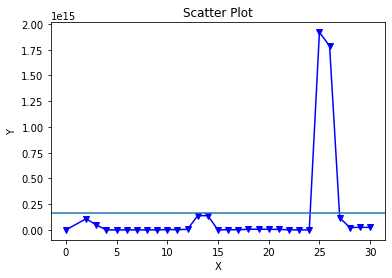

2
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24. 999.  25. 999.
  26.  27.  28.  29.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.]


In [83]:
Clasificacion=ChainMap(Mt)
print(Clasificacion)


- Max-min 

## Implementación ISODATA

El algoritmo N-dimensional de clasificación no surpervisado ISODATA (Interactive Self-Organizing Data Analysis Technique Algorithm) es un algoritmo que calcula los promedios de las clases o agrupaciones que eventualmente están distribuidos en el espacio de decisión. En cada una de las iteracciones re-calcula los promedios y re-clasifica los pixeles de la imagen con respecto a los nuevos promedios. Este proceso continúa hasta que el cambio del número de pixeles en cada clase (cluster) es mínimo respecto a un valor de tolerancia o hasta que se realiza cierto número de iteracciones predefinidas. 

In [71]:
""" Se hace una función "make_gaussians" para simular una distribución de datos bidimensionales por clusteres
esta función tiene una distribución gaussiana aleatoria y recibe como datos la cantidad de clusteres y datos
como se ve en figura abajo costado izquierdo del gráfico """
from numpy import random

def make_gaussians(cluster_n, img_size):
    points = []
    clases = []
    ref_distrs = []
    for i in range(cluster_n):
        mean = (0.1 + 0.8*random.rand(2)) * img_size
        a = (random.rand(2, 2)-0.5)*img_size*0.1
        cov = np.dot(a.T, a) + img_size*0.05*np.eye(2)
        n = 100 + random.randint(900)
#        n = 1 + random.randint(10)
        pts = random.multivariate_normal(mean, cov, n)
        #clas = np.arange(n)
        clas = np.zeros((n,1))
        #print clas.shape
        for j in range (n): clas[j] = i
        points.append( pts )
        clases.append( clas )
        ref_distrs.append( (mean, cov) )
        
    points = np.float32( np.vstack(points) )
    clases = np.float32(np.vstack(clases))
    return points, ref_distrs, clases

In [78]:
#Se definen las subfunciones necesarias para el correcto proceso de ISODATA

#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Copyright 2012 - 2013
# Matías Herranz <matiasherranz@gmail.com>
# Joaquín Tita <joaquintita@gmail.com>
#
# https://github.com/PyRadar/pyradar
#
# This library is free software; you can redistribute it and/or
# modify it under the terms of the GNU Lesser General Public
# License as published by the Free Software Foundation; either
# version 3 of the License, or (at your option) any later version.
#
# This library is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
# Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public
# License along with this library. If not, see <http://www.gnu.org/licenses/>.

from scipy.cluster import vq

#from pyradar.utils import take_snapshot


def initialize_parameters(parameters=None):#Función para inicilizar parametros de manera segura
   
    """
    Auxiliar function to set default values to all the parameters not
    given a value by the user.

    """

    parameters = {} if not parameters else parameters

    def safe_pull_value(parameters, key, default): 
        return parameters.get(key, default)

    # number of clusters desired
    K = safe_pull_value(parameters, 'K', 5)

    # maximum number of iterations
    I = safe_pull_value(parameters, 'I', 100)

    # maximum of number of pairs of clusters which can be merged
    P = safe_pull_value(parameters, 'P', 4)

    # threshold value for  minimum number of samples in each cluster
    # (discarding clusters)
    THETA_M = safe_pull_value(parameters, 'THETA_M', 10)

    # threshold value for standard deviation (for split)
    THETA_S = safe_pull_value(parameters, 'THETA_S', 1)
    # threshold value for pairwise distances (for merge)
    THETA_C = safe_pull_value(parameters, 'THETA_C', 20)

    # percentage of change in clusters between each iteration
    #(to stop algorithm)
    THETA_O = 0.05

    #can use any of both fixed or random
    # number of starting clusters
    #k = np.random.randint(1, K)
    k = safe_pull_value(parameters, 'k', K)

    ret = locals()
    ret.pop('safe_pull_value')
    ret.pop('parameters')
    globals().update(ret)


def quit_low_change_in_clusters(centers, last_centers, iter): #Función para salir del cambio de clusteres iterativo dependiendo de la tolerancia requerida
    """Stop algorithm by low change in the clusters values between each
    iteration.

    :returns: True if should stop, otherwise False.

    """
    quit = False
    if centers.shape == last_centers.shape:
        thresholds = np.abs((centers - last_centers) / (last_centers + 1))

        if np.all(thresholds <= THETA_O):  # percent of change in [0:1]
            quit = True
#            print "Isodata(info): Stopped by low threshold at the centers."
#            print "Iteration step: %s" % iter

    return quit


def merge_clusters(img_class_flat, centers, clusters_list): #Función para unir clusteres cercanos entre sí y eliminar anteriores así hacerlo más preciso
    """
    Merge by pair of clusters in 'below_threshold' to form new clusters.
    """
    pair_dists = compute_pairwise_distances(centers) #Cita la función para calcular la distancia entre centros de clusteres

    first_p_elements = pair_dists[:P]

    below_threshold = [(c1, c2) for d, (c1, c2) in first_p_elements
                                if d < THETA_C]

    if below_threshold:
        k = centers.size
        count_per_cluster = np.zeros(k)
        to_add = np.array([])  # new clusters to add
        to_delete = np.array([])  # clusters to delete

        for cluster in range(0, k):
            result = np.where(img_class_flat == clusters_list[cluster])
            indices = result[0]
            count_per_cluster[cluster] = indices.size

        for c1, c2 in below_threshold: #Ciclo para recalcular el peso de los clusteres y añadir o eliminar estos
            c1_count = float(count_per_cluster[c1]) + 1
            c2_count = float(count_per_cluster[c2])
            factor = 1.0 / (c1_count + c2_count)
            weight_c1 = c1_count * centers[c1]
            weight_c2 = c2_count * centers[c2]

            value = round(factor * (weight_c1 + weight_c2))

            to_add = np.append(to_add, value)
            to_delete = np.append(to_delete, [c1, c2])

        #delete old clusters and their indices from the availables array
        centers = np.delete(centers, to_delete)
        clusters_list = np.delete(clusters_list, to_delete)

        #generate new indices for the new clusters
        #starting from the max index 'to_add.size' times
        start = int(clusters_list.max())
        end = to_add.size + start

        centers = np.append(centers, to_add)
        clusters_list = np.append(clusters_list, xrange(start, end))

        centers, clusters_list = sort_arrays_by_first(centers, clusters_list)

    return centers, clusters_list


def compute_pairwise_distances(centers): #Función para calcular la distancia entre centros de los clusteres
    """
    Compute the pairwise distances 'pair_dists', between every two clusters
    centers and returns them sorted.
    Returns:
           - a list with tuples, where every tuple has in it's first coord the
             distance between to clusters, and in the second coord has a tuple,
             with the numbers of the clusters measured.
             Output example:
                [(d1,(cluster_1,cluster_2)),
                 (d2,(cluster_3,cluster_4)),
                 ...
                 (dn, (cluster_n,cluster_n+1))]
    """
    pair_dists = []
    size = centers.size

    for i in range(0, size):
        for j in range(0, size):
            if i > j:
                d = np.abs(centers[i] - centers[j])
                pair_dists.append((d, (i, j)))

    #return it sorted on the first elem
    return sorted(pair_dists)


def split_clusters(img_flat, img_class_flat, centers, clusters_list):#Función para separar clusteres dependiendo de sus centros
    """
    Split clusters to form new clusters.
    """
    assert centers.size == clusters_list.size, \
        "ERROR: split() centers and clusters_list size are different"

    delta = 10
    k = centers.size
    count_per_cluster = np.zeros(k)
    stddev = np.array([])

    avg_dists_to_clusters = compute_avg_distance(img_flat, img_class_flat,
                                                 centers, clusters_list)
    d = compute_overall_distance(img_class_flat, avg_dists_to_clusters,
                                 clusters_list)

    # compute all the standard deviation of the clusters
    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        count_per_cluster[cluster] = indices.size
        value = ((img_flat[indices] - centers[cluster]) ** 2).sum()
        value /= count_per_cluster[cluster]
        value = np.sqrt(value)
        stddev = np.append(stddev, value)

    cluster = stddev.argmax()
    max_stddev = stddev[cluster]
    max_clusters_list = int(clusters_list.max())

    if max_stddev > THETA_S:
        if avg_dists_to_clusters[cluster] >= d:
            if count_per_cluster[cluster] > (2.0 * THETA_M):
                old_cluster = centers[cluster]
                new_cluster_1 = old_cluster + delta
                new_cluster_2 = old_cluster - delta

                centers = np.delete(centers, cluster)
                clusters_list = np.delete(clusters_list, cluster)

                centers = np.append(centers, [new_cluster_1, new_cluster_2])
                clusters_list = np.append(clusters_list, [max_clusters_list,
                                          (max_clusters_list + 1)])

                centers, clusters_list = sort_arrays_by_first(centers,
                                                              clusters_list)

                assert centers.size == clusters_list.size, \
                   "ERROR: split() centers and clusters_list size are different"

    return centers, clusters_list


def compute_overall_distance(img_class_flat, avg_dists_to_clusters, #Función para encontrar las distancia máximas desde cada centro de cluster
                             clusters_list):
    """
    Computes the overall distance of the samples from their respective cluster
    centers.
    """
    k = avg_dists_to_clusters.size
    total = img_class_flat.size
    count_per_cluster = np.zeros(k)

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        count_per_cluster[cluster] = indices.size

    d = ((count_per_cluster / total) * avg_dists_to_clusters).sum()

    return d


def compute_avg_distance(img_flat, img_class_flat, centers, clusters_list): #Función para operar todas las distancias promedio hasta el centro de cada cluster
    """
    Computes all the average distances to the center in each cluster.
    """
    k = centers.size
    avg_dists_to_clusters = np.array([])

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]

        total_per_cluster = indices.size + 1
        sum_per_cluster = (np.abs(img_flat[indices] - centers[cluster])).sum()

        dj = (sum_per_cluster / float(total_per_cluster))

        avg_dists_to_clusters = np.append(avg_dists_to_clusters, dj)

    return avg_dists_to_clusters


def discard_clusters(img_class_flat, centers, clusters_list): #Función para descartar clusteres teniendo en cuenta la tolerancia definida en ThetaM
    """
    Discard clusters with fewer than THETA_M.
    """
    k = centers.shape[0]
    to_delete = np.array([])

    assert centers.size == clusters_list.size, \
        "ERROR: discard_cluster() centers and clusters_list size are different"

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        total_per_cluster = indices.size
        if total_per_cluster <= THETA_M:
            to_delete = np.append(to_delete, cluster)

    if to_delete.size:
        new_centers = np.delete(centers, to_delete)
        new_clusters_list = np.delete(clusters_list, to_delete)
    else:
        new_centers = centers
        new_clusters_list = clusters_list

    new_centers, new_clusters_list = sort_arrays_by_first(new_centers,
                                                          new_clusters_list)

#        shape_bef = centers.shape[0]
#        shape_aft = new_centers.shape[0]
#        print "Isodata(info): Discarded %s clusters." % (shape_bef - shape_aft)

#        if to_delete.size:
#            print "Clusters discarded %s" % to_delete

    assert new_centers.size == new_clusters_list.size, \
        "ERROR: discard_cluster() centers and clusters_list size are different"

    return new_centers, new_clusters_list


def update_clusters(img_flat, img_class_flat, centers, clusters_list): #Función para actualizar en la lista las caracteristicas de los clusteres (centro, suma y tamaño de los valores, entre otros)
    """ Update clusters. """
    k = centers.shape[0]
    new_centers = np.array([])
    new_clusters_list = np.array([])

    assert centers.size == clusters_list.size, \
        "ERROR: update_clusters() centers and clusters_list size are different"

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        #get whole cluster
        cluster_values = img_flat[indices]
        #sum and count the values
        sum_per_cluster = cluster_values.sum()
        total_per_cluster = (cluster_values.size) + 1
        #compute the new center of the cluster
        new_cluster = sum_per_cluster / total_per_cluster

        new_centers = np.append(new_centers, new_cluster)
        new_clusters_list = np.append(new_clusters_list, cluster)

    new_centers, new_clusters_list = sort_arrays_by_first(new_centers,
                                                          new_clusters_list)

    assert new_centers.size == new_clusters_list.size, \
        "ERROR: update_clusters() centers and clusters_list size are different"

    return new_centers, new_clusters_list


def initial_clusters(img_flat, k, method="linspace"): #Función para definir los clusteres iniciales con los datos originales, centro y datos aleatorios
    """
    Define initial clusters centers as startup.
    By default, the method is "linspace". Other method available is "random".
    """
    methods_availables = ["linspace", "random"]

    assert method in methods_availables, "ERROR: method %s is no valid." \
                                         "Methods availables %s" \
                                         % (method, methods_availables)
    if method == "linspace":
        max, min = img_flat.max(), img_flat.min()
        centers = np.linspace(min, max, k)
    elif method == "random":
        start, end = 0, img_flat.size
        indices = np.random.randint(start, end, k)
        centers = img_flat.take(indices)

    return centers


def sort_arrays_by_first(centers, clusters_list): #Función para ordenar los centros y clusteres de menor a mayor
    """
    Sort the array 'centers' and the with indices of the sorted centers
    order the array 'clusters_list'.
    Example: centers=[22, 33, 0, 11] and cluster_list=[7,6,5,4]
    returns  (array([ 0, 11, 22, 33]), array([5, 4, 7, 6]))
    """
    assert centers.size == clusters_list.size, \
    "ERROR: sort_arrays_by_first centers and clusters_list size are not equal"

    indices = np.argsort(centers)

    sorted_centers = centers[indices]
    sorted_clusters_list = clusters_list[indices]

    return sorted_centers, sorted_clusters_list


def isodata_classification(img, parameters=None): #Función general para la definición del algoritmo ISODATA
    """
    Classify a numpy 'img' using Isodata algorithm.
    Parameters: a dictionary with the following keys.
            - img: an input numpy array that contains the image to classify.
            - parameters: a dictionary with the initial values.
              If 'parameters' are not specified, the algorithm uses the default
              ones.
                  + number of clusters desired.
                    K = 15
                  + max number of iterations.
                    I = 100
                  + max number of pairs of clusters which can be ,erged.
                    P = 2
                  + threshold value for min number in each cluster.
                    THETA_M = 10
                  + threshold value for standard deviation (for split).
                    THETA_S = 0.1
                  + threshold value for pairwise distances (for merge).
                    THETA_C = 2
                  + threshold change in the clusters between each iter.
                    THETA_O = 0.01
        Note: if some(or all) parameters are nos providen, default values
              will be used.
    Returns:
            - img_class: a numpy array with the classification.
    """
    global K, I, P, THETA_M, THETA_S, THEHTA_C, THETA_O, k
    initialize_parameters(parameters) #Inicio seguro de los parametros

    N, M = img.shape  # for reshaping at the end
    img_flat = img.flatten()
    clusters_list = np.arange(k)  # number of clusters availables

    print ("Isodata(info): Starting algorithm with %s classes" % k)
    centers = initial_clusters(img_flat, k, "linspace") #Inicialización de los centros de clusteres originales

    for iter in range(0, I):
#        print "Isodata(info): Iteration:%s Num Clusters:%s" % (iter, k)
        last_centers = centers.copy()
        # assing each of the samples to the closest cluster center
        img_class_flat, dists = vq.vq(img_flat, centers)

        centers, clusters_list = discard_clusters(img_class_flat,
                                                  centers, clusters_list) #Descarte de clusteres
        centers, clusters_list = update_clusters(img_flat,
                                                 img_class_flat,
                                                 centers, clusters_list) #Actualización de la lista de clusteres
        k = centers.size

        if k <= (K / 2.0):  # too few clusters => split clusters
            centers, clusters_list = split_clusters(img_flat, img_class_flat,
                                                    centers, clusters_list) #Separación de clusteres dependiendo de parametro K

        elif k > (K * 2.0):  # too many clusters => merge clusters
            centers, clusters_list = merge_clusters(img_class_flat, centers, #unir clusteres según parametro K
                                                    clusters_list)
        else:  # nor split or merge are needed
            pass

        k = centers.size
###############################################################################
        if quit_low_change_in_clusters(centers, last_centers, iter):
            break

#        take_snapshot(img_class_flat.reshape(N, M), iteration_step=iter)
###############################################################################
    print ("Isodata(info): Finished with %s classes" % k)
    print ("Isodata(info): Number of Iterations: %s" % (iter + 1))

    return img_class_flat.reshape(N, M) #impresión de grafico final




def isodata_classification_DATA(data, parameters=None): #Función similar a la anterior que retorna los datos y no el gráfico
    """
    Classify a numpy 'data array' using Isodata algorithm.
    Parameters: a dictionary with the following keys.
            - img: an input numpy array that contains the image to classify.
            - parameters: a dictionary with the initial values.
              If 'parameters' are not specified, the algorithm uses the default
              ones.
                  + number of clusters desired.
                    K = 15
                  + max number of iterations.
                    I = 100
                  + max number of pairs of clusters which can be ,erged.
                    P = 2
                  + threshold value for min number in each cluster.
                    THETA_M = 10
                  + threshold value for standard deviation (for split).
                    THETA_S = 0.1
                  + threshold value for pairwise distances (for merge).
                    THETA_C = 2
                  + threshold change in the clusters between each iter.
                    THETA_O = 0.01
        Note: if some(or all) parameters are nos providen, default values
              will be used.
    Returns:
            - img_class: a numpy array with the classification.
    """
    global K, I, P, THETA_M, THETA_S, THEHTA_C, THETA_O, k
    initialize_parameters(parameters)

    #N, M = img.shape  # for reshaping at the end
    data_flat = data.flatten()
    clusters_list = np.arange(k)  # number of clusters availables

    print ("Isodata(info): Starting algorithm with %s classes" % k)
    centers = initial_clusters(data_flat, k, "linspace")

    for iter in range(0, I):
#        print "Isodata(info): Iteration:%s Num Clusters:%s" % (iter, k)
        last_centers = centers.copy()
        # assing each of the samples to the closest cluster center
        data_class_flat, dists = vq.vq(data_flat, centers)

        centers, clusters_list = discard_clusters(data_class_flat,
                                                  centers, clusters_list)
        centers, clusters_list = update_clusters(data_flat,
                                                 data_class_flat,
                                                 centers, clusters_list)
        k = centers.size

        if k <= (K / 2.0):  # too few clusters => split clusters
            centers, clusters_list = split_clusters(data_flat, data_class_flat,
                                                    centers, clusters_list)

        elif k > (K * 2.0):  # too many clusters => merge clusters
            centers, clusters_list = merge_clusters(data_class_flat, centers,
                                                    clusters_list)
        else:  # nor split or merge are needed
            pass

        k = centers.size
###############################################################################
        if quit_low_change_in_clusters(centers, last_centers, iter):
            break

#        take_snapshot(img_class_flat.reshape(N, M), iteration_step=iter)
###############################################################################
    print ("Isodata(info): Finished with %s classes" % k)
    print ("Isodata(info): Number of Iterations: %s" % (iter + 1))

    #return img_class_flat.reshape(N, M)
    return data_class_flat


(9630, 2)
[[ 0.]
 [ 0.]
 [ 0.]
 ...
 [14.]
 [14.]
 [14.]]
14.0
0.0
[ 0.   3.5  7.  10.5 14. ]
Aux
Isodata(info): Starting algorithm with 5 classes
Isodata(info): Finished with 5 classes
Isodata(info): Number of Iterations: 2
[0 0 0 ... 4 4 4]
(9630,)


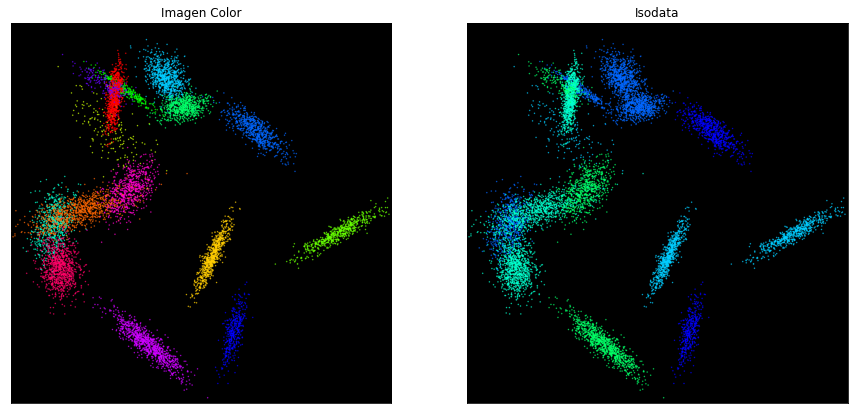

In [84]:
#Definición de parametros para la ejecución del algoritmo

cluster_n = 15
K =5            #K siempre debe ser menor al número de clusteres
img_size = 1200


# generating bright palette
colors = np.zeros((1, cluster_n, 3), np.uint8)
colors[0,:] = 255
colors[0,:,0] = np.arange(0, 180, 180.0/cluster_n)
colors = cv.cvtColor(colors, cv.COLOR_HSV2BGR)[0]

#while True:
points, D, clases = make_gaussians(cluster_n, img_size)

print (points.shape)
#print (points)
points_flat = points.flatten()
#print (points_flat)

print (clases)
print (clases.max())
print (clases.min())
max, min = clases.max(), clases.min()
centers = np.linspace(min, max, K)
print (centers)

params = {"K": K, "I" : 100, "P" : 4, "THETA_M" : 10, "THETA_S" : 0.1, #PArametros de entrada a la función ISODATA
          "THETA_C" : 2, "THETA_O" : 0.01}

print ("Aux")
class_data = isodata_classification_DATA(clases, parameters=params)
print (class_data)
print (class_data.shape)

#Visualizacion Distribuciones originales
img = np.zeros((img_size, img_size, 3), np.uint8)
for (x, y), label in zip(np.int32(points), np.int32(np.transpose(clases.flat))):
    c = colors[label]
    cv.circle(img, (x, y), 2, (int(c[0]),int(c[1]),int(c[2])), -1)
    
#Visualizacion Isodata
img2 = np.zeros((img_size, img_size, 3), np.uint8)
for (x, y), label in zip(np.int32(points), class_data.ravel()):
    c = colors[label]
    cv.circle(img2, (x, y), 2, (int(c[0]),int(c[1]),int(c[2])), -1)

plt.figure(1,figsize=(15,15))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Imagen Color'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img2,cmap = 'gray')
plt.title('Isodata'), plt.xticks([]), plt.yticks([])

plt.show()




## Referencias

    - http://www.scielo.org.co/scielo.php?script=sci_arttext&pid=S0304-28472005000100004